In [ ]:
%run ../talktools.py

# sqlite3 interface through Python

UC Berkeley Python class (AY250; 2013—2022)

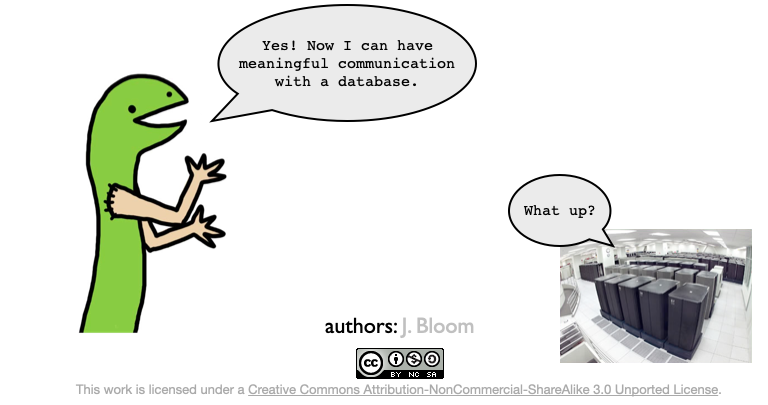

## sqlite3 module

- Built-in SQL database access
- database is stored as a file (or in RAM)
- Syntax uses Structured Query Language
- Attempts to protect the database from corruption

First, we show simple database creation.

In [ ]:
import sqlite3

connection = sqlite3.connect("/tmp/example2.db")

cursor = connection.cursor()

sql_cmd = """CREATE TABLE dan_aykroyd (id INTEGER PRIMARY KEY AUTOINCREMENT,
    skit_title TEXT, air_date DATE, season INT, ep INT, role TEXT)"""

cursor.execute(sql_cmd)

Then, we insert some data.

In [ ]:
skit_data = [
    ("Trojan Horse Home Security", "10/11/75", 1, 1, "Kenny Vorstrather"), 
    ("E. Buzz Miller's Animal Kingdom", "2/25/78", 3, 12, "E. Buzz Miller"), 
    ("The Coneheads at Home", "10/21/78", 4, 3, "Beldar Conehead")]

for role in skit_data:
    sql_cmd = ("INSERT INTO dan_aykroyd (skit_title, air_date, season, " +     
        "ep, role) VALUES " + str(role))
    cursor.execute(sql_cmd)

Lastly, we run a simple query on the database we just made.

In [ ]:
sql_cmd = "SELECT * FROM dan_aykroyd WHERE air_date > '10/12/75'"
cursor.execute(sql_cmd)

db_info = cursor.fetchall()
for entry in db_info: 
    print(entry)
    
connection.commit()
connection.close()

Create another table, enter data, run simple join on columns using both tables.

In [ ]:
connection = sqlite3.connect("/tmp/example2.db")

cursor = connection.cursor()
sql_cmd = """CREATE TABLE jane_curtin (id INTEGER PRIMARY KEY AUTOINCREMENT,
    skit_title TEXT, air_date DATE, season INT, ep INT, role TEXT)"""

cursor.execute(sql_cmd)

skit_data = [
    ("Teen Talk", "7/24/76", 1, 23, "Jane"), 
    ("The Snakehandling O'Sheas", "9/25/76", 2, 2, "Jane O'Shea"), 
    ("The Coneheads at Home", "10/21/78", 4, 3, "Prymaat Conehead")]

for role in skit_data:
    sql_cmd = ("INSERT INTO jane_curtin (skit_title, air_date, season, " +     
        "ep, role) VALUES " + str(role))
    cursor.execute(sql_cmd)

# Our query is to find which skits featured both Dan Aykroyd and Jane Curtin.
sql_cmd = """SELECT dan_aykroyd.skit_title, dan_aykroyd.air_date, 
    dan_aykroyd.season, dan_aykroyd.ep, dan_aykroyd.role, jane_curtin.role
    FROM dan_aykroyd, jane_curtin WHERE 
    dan_aykroyd.skit_title = jane_curtin.skit_title AND 
    dan_aykroyd.air_date = jane_curtin.air_date"""
cursor.execute(sql_cmd)
db_info = cursor.fetchall()
for entry in db_info: 
    print(entry)

We can also run a left join.

In [ ]:
connection = sqlite3.connect("/tmp/example2.db")

cursor = connection.cursor()

sql_cmd = """SELECT dan_aykroyd.skit_title, dan_aykroyd.air_date, 
    dan_aykroyd.season, dan_aykroyd.ep, dan_aykroyd.role, jane_curtin.role
    FROM dan_aykroyd LEFT JOIN jane_curtin ON 
    dan_aykroyd.skit_title = jane_curtin.skit_title AND 
    dan_aykroyd.air_date = jane_curtin.air_date"""

cursor.execute(sql_cmd)
db_info = cursor.fetchall()
for entry in db_info: 
    print(entry)
    
connection.close()

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/SQL_Joins.svg/2000px-SQL_Joins.svg.png">

See also: https://en.wikipedia.org/wiki/Join_(SQL)

# Example with Plotting
Emphasis on data retrieval

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

In [ ]:
from urllib.request import urlopen

In [ ]:
import sqlite3, datetime
import pandas as pd
import os
import numpy as np

import requests

secret = open(".secret", "r").read().strip()

def get_stock_data(stock_symbol):
    """ get data at https://data.nasdaq.com/
        you'll need you sign up for your own API key
    """
    fout = f"{stock_symbol}.csv"
    if not os.path.exists(fout):
        url = (f"http://api.marketstack.com/v1/eod?"
              f"access_key={secret}&symbols={stock_symbol}&limit=1000")
        response = requests.get(url)
        df =  pd.DataFrame(response.json()["data"])
        df.to_csv(fout)
    else:
        df = pd.read_csv(fout)
    
    return df

In [ ]:
## Gamestonk
df = get_stock_data("GME")
df

Here we create a table, download the stock data, and populate the table with the data.

In [ ]:
connection = sqlite3.connect(":memory:")

cursor = connection.cursor()
sql_cmd = """CREATE TABLE stocks (id INTEGER PRIMARY KEY AUTOINCREMENT,
    symbol TEXT, day INT, open FLOAT, high FLOAT, low FLOAT, close FLOAT,
    volume FLOAT, adj_close FLOAT)"""
cursor.execute(sql_cmd)

stock_symbols = ["GME" ,"TSLA", "SNOW"]

ref_date = datetime.date(2022, 2, 28)

for stock_symbol in stock_symbols:
    
    data = get_stock_data(stock_symbol)
    print(f"Inserting {stock_symbol} data:", end=" ")
    for i, row in data.iterrows():
        
        year = int(row["date"].split("-")[0])
        month = int(row["date"].split("-")[1])
        day = int(row["date"].split("-")[2].split("T")[0])
        
        stock_date = datetime.date(year, month, day)
        
        sql_cmd = "INSERT INTO stocks" + \
                  "(symbol, day, open, high, low, close,volume, adj_close)" + \
                 f" VALUES ('{stock_symbol}',{(stock_date - ref_date).days}," + \
                 f"""{row["open"]},{row["high"]},{row["low"]},{row["close"]},"""  + \
                 f"""{row["volume"]},{row["adj_close"]})"""
        cursor.execute(sql_cmd)
        connection.commit()
    
    print("done.")


We can plot from the table easily, using the query to select out only the data we want to visualize.

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

for ss in stock_symbols:
    sql_cmd = "SELECT day, adj_close FROM stocks WHERE symbol == '" + ss + "'"
    cursor.execute(sql_cmd)
    db_info = np.array(cursor.fetchall())
    ax.plot(db_info[:, 0], db_info[:, 1], label=ss)

ax.legend(loc=2)
ax.set_xlabel("Days since 2/2/2028")
ax.set_ylabel("Stock Price ($)")
f.suptitle("Stock Performance")

## Pandas can work with SQLite Directly

In [ ]:
import pandas as pd

df = pd.read_sql_query("SELECT symbol, day, adj_close FROM stocks;", connection)
df = df.pivot(index='day', columns='symbol', values='adj_close')

In [ ]:
df.plot(figsize=(10,7))